<a href="https://colab.research.google.com/github/esciencecenter-digital-skills/2021-11-17-surf-bootcamp-parallel-python/blob/main/Parallel_Programming_in_Python_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Parallel programming

# Parallelizing a Python application

In order to recognize the advantages of parallelization we need an algorithm that is easy to parallelize, but still complex enough to take a few seconds of CPU time. To not scare away the interested reader, we need this algorithm to be understandable and, if possible, also interesting. We chose a classical algorithm for demonstrating parallel programming: estimating the value of number π.

The algorithm we present is one of the classical examples of the power of Monte-Carlo methods. This is an umbrella term for several algorithms that use random numbers to approximate exact results. We chose this algorithm because of its simplicity and straightforward geometrical interpretation.

We can compute the value of π using a random number generator. We count the points falling inside the blue circle M compared to the green square N. Then π is approximated by the ratio 4M/N.

![Computing Pi](https://carpentries-incubator.github.io/lesson-parallel-python/fig/calc_pi_3_wide.svg)

## Exercise 1
Use only standard Python and the function `random.uniform`. The function should have the following interface:

```python
import random
def calc_pi(N):
    """Computes the value of pi using N random samples."""
    ...
    for i in range(N):
        # take a sample
        ...
    return ...
```

Can you explain why this implementation is so slow?

## A Vectorized version in NumPy

We cannot talk about parallel programming without first making our implementation a bit faster. After all, what use is it to parallelise our code when we can gain much more in performance by other means?

The secret of optimizing Python code and later also when it comes to parallelisation, is to take things away from Python. Even as a scripting language Python was never designed for efficiency, rather it is a glue language, telling how to use and combine more efficient lower level routines, a bit like a puppet player.

You may already be familiar with optimizing a Python program by rewriting it in a **vectorized** form using NumPy.

In [ ]:
import numpy as np

def calc_pi_numpy(N):
    # Simulate impact coordinates
    pts = np.random.uniform(-1, 1, (2, N))
    # Count number of impacts inside the circle
    M = np.count_nonzero((pts**2).sum(axis=0) < 1)
    return 4 * M / N

In [ ]:
calc_pi_numpy(10**8)

3.14175096

The downside of this method is that it can take a lot of memory! Try running this function with a larger input size while running a system monitor (if you run this code locally). One easy way of both parallelising this function and solving the memory issue, is to use Dask Arrays. This interface mirrors most of what you can do with ordinary NumPy, and parallelises for free! **Try to guess at how to translate our `calc_pi_numpy` function to a Dask enabled function.**

In [ ]:
from dask import array as da

def calc_pi_dask(N):
  ...

Now if we try to run this code something strange happens:

In [ ]:
calc_pi_dask(10**8)

dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

We need to tell Dask explicitely that we'd like to compute our result.

In [ ]:
calc_pi_dask(10**8).compute()

3.14176328

We can actually do much better than that. Let's try Numba. Numba is a **just-in-time** compiler for a subset of Python. You can have it compile parts of your Python code to machine code. For simple operations it is as easy as pasting the `@numba.jit` decorator in front of your function definition. **Use it on your first pure Python implementation of `calc_pi`.**

In [ ]:
import numba
import random

@numba.jit(nopython=True, nogil=True)
def calc_pi_numba(N):
    M = 0
    for i in range(N):
        # Simulate impact coordinates
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)

        # True if impact happens inside the circle
        if x**2 + y**2 < 1.0:
            M += 1
    return 4 * M / N

In [ ]:
calc_pi_numba(10**9)

3.14167996

Those of you that read documentation could find out that the `numba.jit` function accepts an argument `parallel=True`, but we're not going to use that since it is much more instructive to parallelise this function with Dask's `delayed` interface.

In [ ]:
from dask import delayed

In [ ]:
@delayed
def add(a, b):
  return a + b

In [ ]:
x_p = add(1, 2)

In [ ]:
type(x_p)

dask.delayed.Delayed

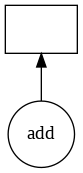

In [ ]:
x_p.visualize()

In [ ]:
y_p = add(x_p, 3)
z_p = add(y_p, x_p)

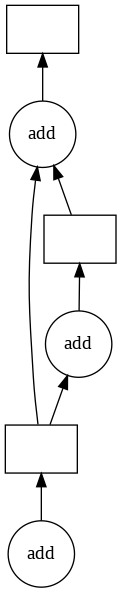

In [ ]:
z_p.visualize()

In [ ]:
@delayed
def sqr(x):
  return x * x

@delayed
def mean(*args):
  return sum(args) / len(args)

In [ ]:
sample = np.random.normal(size=10)

In [ ]:
sqr_mean = mean(*map(sqr, sample))

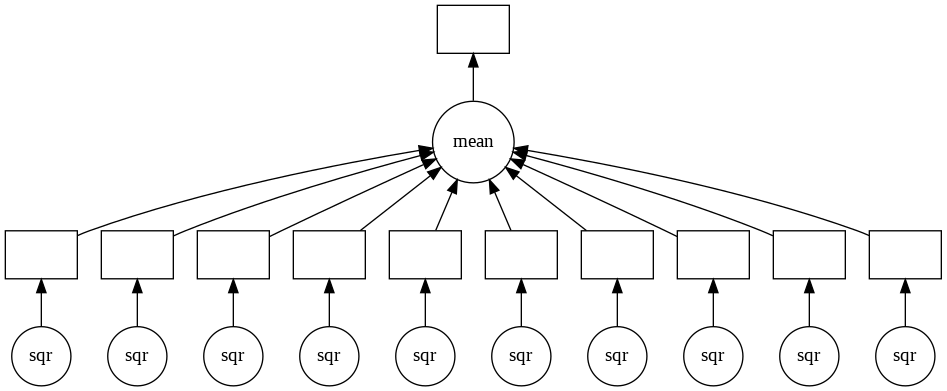

In [ ]:
sqr_mean.visualize()

In [ ]:
sqr_mean.compute()

0.7671437505810657